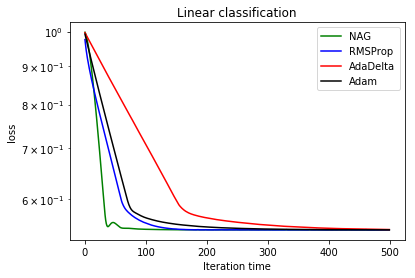

耗时 0:05:45.147613
NAG的准确率为 0.7637737239727289
RMSProp的准确率为 0.7637737239727289
AdaDelta的准确率为 0.7637737239727289
Adam的准确率为 0.7637737239727289


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import math
import random as rd
import datetime

starttime = datetime.datetime.now()

def gradient(w,x,y,lamda):
    i=0
    a=np.zeros((col+1,1))
    while(i<max_sample):
        if(y[i][0]*(w.T.dot(x[i]))<1):
            yi=y[i][0]
            Xi=x[i].reshape(col+1,1)
            a+=-yi*Xi
            i+=1
        else:
            i+=1
    
    g=a/max_sample+lamda*w
    return g



def loss(w,x,y):
    j=0
    l=0
    while(j<row_test):
        if(y[j][0]*(w.T.dot(x[j]))<1):
            l+=1-y[j][0]*(w.T.dot(x[j]))
        j+=1
    return l/row_test

def final_right_rate(w,x,y):
    right=0
    j=0
    while(j<row_test):
        if(y[j][0]*w.T.dot(x[j])>0):
            right+=1
        j+=1
    return right/row_test



#读取实验训练集和测试集
X_train,y_train=load_svmlight_file("G:/a9a")
X_test,y_test=load_svmlight_file("G:/a9a.t",123)


#记录训练，测试集输入输出矩阵的行数和列数
row_train,col_train=X_train.shape
y_train=y_train.reshape(row_train,1)
row_test,col_test=X_test.shape
y_test=y_test.reshape(row_test,1)
col=col_train
#现在关于数据集的变量有三：row_test,row_train,col

#注意输入集需要拓展
X_train=X_train.toarray()
X_train=np.column_stack((X_train,np.ones((row_train,1))))
X_test = X_test.toarray()
X_test=np.column_stack((X_test,np.ones((row_test,1))))

#初始化参数 选择全零初始化
#注意，线性分类所用的矩阵需要拓展
#NAG参数初始化:
W_NAG=np.zeros((col+1,1))
V_NAG=np.zeros((col+1,1))
r_NAG=0.9
#RMSProp参数初始化：
W_RMSProp=np.zeros((col+1,1))
Gt_RMSProp=np.zeros((col+1,1))
r_RMSProp=0.9
e_RMSProp=10**-8
#AdaDelta参数初始化：
W_AdaDelta=np.zeros((col+1,1))
Gt_AdaDelta=np.zeros((col+1,1))
delta=np.zeros((col+1,1))
w_delta=np.zeros((col+1,1))
r_AdaDelta=0.95
e_AdaDelta=10**-8
#Adam参数初始化
W_Adam=np.zeros((col+1,1))
Gt_Adam=np.zeros((col+1,1))
m_Adam=np.zeros((col+1,1))
B_Adam=0.9
r_Adam=0.999
e_Adam=10**-8

#确定学习率和训练次数
lamda=1
n=0.001
count=0
max_count=500

#用数组记录loss
loss_NAG_validation=np.zeros(max_count)
loss_RMSProp_validation=np.zeros(max_count)
loss_AdaDelta_validation=np.zeros(max_count)
loss_Adam_validation=np.zeros(max_count)

#采用SGD 每轮学习抽取5000个随机样本
max_sample=5000
while(count<max_count):
    #random_array数组保存的是被选中的样本序号
    random_array=np.random.randint(row_train,size=(max_sample,))
    
    #需要拓展
    gt_NAG=np.zeros((col+1,1))
    gt_RMSProp=np.zeros((col+1,1))
    gt_AdaDelta=np.zeros((col+1,1))
    gt_Adam=np.zeros((col+1,1))
  
    X_sample=X_train[random_array,:]
    y_sample=y_train[random_array,:]
    
    #开始计算NAG的W
    gt_NAG=gradient(W_NAG-r_NAG*V_NAG,X_sample,y_sample,lamda)
    V_NAG=r_NAG*V_NAG+n*gt_NAG#别忘了这里是 学习率/随机样本量
    W_NAG=W_NAG-V_NAG
    
     #开始计算RMSProp的W
    gt_RMSProp=gradient(W_RMSProp,X_sample,y_sample,lamda)
    Gt_RMSProp=r_RMSProp*Gt_RMSProp+np.multiply((1-r_RMSProp)*gt_RMSProp,gt_RMSProp)
    W_RMSProp=W_RMSProp-n*np.multiply((Gt_RMSProp+e_RMSProp)**(-0.5),gt_RMSProp)
   
    #开始计算AdaDelta的W
    gt_AdaDelta=gradient(W_AdaDelta,X_sample,y_sample,lamda)
    Gt_AdaDelta=r_AdaDelta*Gt_AdaDelta+np.multiply((1-r_AdaDelta)*gt_AdaDelta,gt_AdaDelta)
    w_delta=-np.multiply(((delta+e_AdaDelta)/(Gt_AdaDelta+e_AdaDelta))**(0.5),gt_AdaDelta)
    W_AdaDelta=W_AdaDelta+w_delta
    delta=r_AdaDelta*delta+np.multiply((1-r_AdaDelta)*w_delta,w_delta)
    
    #开始计算Adam的W
    gt_Adam=gradient(W_Adam,X_sample,y_sample,lamda)
    m_Adam=B_Adam*m_Adam+(1-B_Adam)*gt_Adam
    Gt_Adam=r_Adam*Gt_Adam+np.multiply((1-r_Adam)*gt_Adam,gt_Adam)
    time=count+1
    a_Adam=n*((1-r_Adam**time)**0.5)/(1-B_Adam**time)
    W_Adam=W_Adam-a_Adam*m_Adam*((Gt_Adam+e_Adam)**-0.5)
    
    #到此梯度计算完毕，一次学习中的W更新完毕

    #开始计算loss
    loss_NAG_validation[count]=loss(W_NAG,X_test,y_test)+lamda*0.5*W_NAG.T.dot(W_NAG)
    loss_RMSProp_validation[count]=loss(W_RMSProp,X_test,y_test)+lamda*0.5*W_RMSProp.T.dot(W_RMSProp)
    loss_AdaDelta_validation[count]=loss(W_AdaDelta,X_test,y_test)+lamda*0.5*W_AdaDelta.T.dot(W_AdaDelta)
    loss_Adam_validation[count]=loss(W_Adam,X_test,y_test)+lamda*0.5*W_Adam.T.dot(W_Adam)
    count+=1
    
right_rate_NAG=final_right_rate(W_NAG,X_test,y_test)   
right_rate_RMSProp=final_right_rate(W_RMSProp,X_test,y_test)   
right_rate_AdaDelta=final_right_rate(W_AdaDelta,X_test,y_test)   
right_rate_Adam=final_right_rate(W_Adam,X_test,y_test)   
    
x=range(max_count)
y_NAG = [loss_NAG_validation[count] for count in x]
y_RMSProp=[loss_RMSProp_validation[count] for count in x]
y_AdaDelta = [loss_AdaDelta_validation[count] for count in x]
y_Adam = [loss_Adam_validation[count] for count in x]

plt.plot(x, y_NAG,'g-', label='NAG')  
plt.plot(x,y_RMSProp,'b-', label='RMSProp')
plt.plot(x, y_AdaDelta,'r-', label='AdaDelta')
plt.plot(x, y_Adam,'k-', label='Adam')  
plt.yscale('log')
plt.legend()

plt.xlabel('Iteration time')
plt.ylabel('loss')
plt.title('Linear classification')
plt.show()

endtime = datetime.datetime.now()
print ('耗时',endtime - starttime)
print('NAG的准确率为',right_rate_NAG)
print('RMSProp的准确率为',right_rate_RMSProp)
print('AdaDelta的准确率为',right_rate_AdaDelta)
print('Adam的准确率为',right_rate_Adam)